In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from datetime import datetime, timedelta
from fbprophet import Prophet
from tqdm import tqdm
import lightgbm
from korean_lunar_calendar import KoreanLunarCalendar
import os

# 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# 그래프의 크기
plt.rcParams['figure.figsize'] = 10,5
# 글자 크기
plt.rcParams['font.size'] = 12
# 폰트 설정 시 - 기호 깨지는 것 방지
plt.rcParams['axes.unicode_minus'] = False

# 경고 끄기
pd.set_option('mode.chained_assignment', None)
warnings.filterwarnings(action='ignore')

# 데이터 로드

In [32]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DACON/가스공급량 수요예측 모델개발/data/한국가스공사_시간별 공급량_20181231.csv', encoding='cp949')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DACON/가스공급량 수요예측 모델개발/data/test.csv')

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368088 entries, 0 to 368087
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   연월일     368088 non-null  object 
 1   시간      368088 non-null  int64  
 2   구분      368088 non-null  object 
 3   공급량     368088 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 11.2+ MB


# 기상데이터 활용

- 경기도

In [7]:
ggWeather13 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DACON/가스공급량 수요예측 모델개발/data/weather_경기/서울_2013.csv', encoding = 'euc-kr')
ggWeather14 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DACON/가스공급량 수요예측 모델개발/data/weather_경기/서울_2014.csv', encoding = 'euc-kr')
ggWeather15 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DACON/가스공급량 수요예측 모델개발/data/weather_경기/서울_2015.csv', encoding = 'euc-kr')
ggWeather16 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DACON/가스공급량 수요예측 모델개발/data/weather_경기/서울_2016.csv', encoding = 'euc-kr')
ggWeather17 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DACON/가스공급량 수요예측 모델개발/data/weather_경기/서울_2017.csv', encoding = 'euc-kr')
ggWeather18 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DACON/가스공급량 수요예측 모델개발/data/weather_경기/서울_2018.csv', encoding = 'euc-kr')
# ggWeather19 = pd.read_csv('./data/weather/경기_2019.csv', encoding = 'euc-kr')

In [11]:
ggWeather13

,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),습도(%),적설(cm),지면온도(°C)
0,108,서울,2013-01-01 00:00,-8.3,NaN,3.6,56.0,6.4,-3.3
1,108,서울,2013-01-01 01:00,-8.5,NaN,4.0,57.0,6.4,-3.4
2,108,서울,2013-01-01 02:00,-8.4,NaN,4.0,60.0,6.4,-3.4
3,108,서울,2013-01-01 03:00,-8.1,NaN,3.4,58.0,6.4,-3.4
4,108,서울,2013-01-01 04:00,-8.2,NaN,3.8,58.0,6.4,-3.4
...,...,...,...,...,...,...,...,...,...
8755,108,서울,2013-12-31 19:00,5.5,NaN,3.6,62.0,NaN,0.1
8756,108,서울,2013-12-31 20:00,5.2,NaN,2.7,70.0,NaN,0.1
8757,108,서울,2013-12-31 21:00,4.9,NaN,3.9,64.0,NaN,0.1
8758,108,서울,2013-12-31 22:00,4.2,NaN,3.6,62.0,NaN,0.1


In [12]:
ggWeather = pd.concat([ggWeather13, ggWeather14, ggWeather15, ggWeather16, ggWeather17, ggWeather18], axis = 0, ignore_index=True)

In [13]:
ggWeather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52580 entries, 0 to 52579
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   지점        52580 non-null  int64  
 1   지점명       52580 non-null  object 
 2   일시        52580 non-null  object 
 3   기온(°C)    52578 non-null  float64
 4   강수량(mm)   4944 non-null   float64
 5   풍속(m/s)   52538 non-null  float64
 6   습도(%)     52537 non-null  float64
 7   적설(cm)    2395 non-null   float64
 8   지면온도(°C)  52527 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 3.6+ MB


강수량, 적설의 데이터는 결측이 너무 많기 때문에 삭제하는 쪽으로 처리

In [14]:
ggWeather['지점명'].unique()

array(['서울'], dtype=object)

In [15]:
ggWeather.isna().sum()

지점              0
지점명             0
일시              0
기온(°C)          2
강수량(mm)     47636
풍속(m/s)        42
습도(%)          43
적설(cm)      50185
지면온도(°C)       53
dtype: int64

In [16]:
ggWeather['지점명'].value_counts()

서울    52580
Name: 지점명, dtype: int64

## 날씨 데이터 결측치 처리

- 지점별로 52584 row가 필요

In [17]:
ggWeather['일시'] = pd.to_datetime(ggWeather['일시'])

In [23]:
print(len(train[train['구분'] == 'A']))
print(len(train[train['구분'] == 'B']))
print(len(train[train['구분'] == 'C']))
print(len(train[train['구분'] == 'D']))
print(len(train[train['구분'] == 'E']))
print(len(train[train['구분'] == 'G']))
print(len(train[train['구분'] == 'H']))

52584
52584
52584
52584
52584
52584
52584


In [33]:
train[['시간']] = train[['시간']] - 1
for k in range(len(train)) :
        if train.iloc[k]['시간'] in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] :
          train.iloc[k, 1] = str(train.iloc[k]['시간']).zfill(2)

In [34]:
train['일시'] = train['연월일'].astype('str') + '-' + train['시간'].astype('str')

# 데이터 타입 변경
train['일시']= pd.to_datetime(train['일시'])

In [27]:
ggWeather.set_index('일시', inplace=True)

In [ ]:
# suwon = ggWeather[ggWeather['지점명']=='수원']
# dongducheon = ggWeather[ggWeather['지점명']=='동두천']
# icheon = ggWeather[ggWeather['지점명']=='이천']
# paju = ggWeather[ggWeather['지점명']=='파주']
# yangpyeong = ggWeather[ggWeather['지점명']=='양평']

- 2013~2018년 중 누락된 '일시' 채워넣기

In [ ]:
# dongducheon = dongducheon.resample('1H').first().reset_index()
# icheon = icheon.resample('1H').first().reset_index()
# paju = paju.resample('1H').first().reset_index()
# yangpyeong = yangpyeong.resample('1H').first().reset_index()
# suwon = suwon.resample('1H').first().reset_index()

In [28]:
ggWeather = ggWeather.resample('1H').first().reset_index()

In [29]:
ggWeather.shape

(52584, 9)

In [30]:
ggWeather

,일시,지점,지점명,기온(°C),강수량(mm),풍속(m/s),습도(%),적설(cm),지면온도(°C)
0,2013-01-01 00:00:00,108.0,서울,-8.3,NaN,3.6,56.0,6.4,-3.3
1,2013-01-01 01:00:00,108.0,서울,-8.5,NaN,4.0,57.0,6.4,-3.4
2,2013-01-01 02:00:00,108.0,서울,-8.4,NaN,4.0,60.0,6.4,-3.4
3,2013-01-01 03:00:00,108.0,서울,-8.1,NaN,3.4,58.0,6.4,-3.4
4,2013-01-01 04:00:00,108.0,서울,-8.2,NaN,3.8,58.0,6.4,-3.4
...,...,...,...,...,...,...,...,...,...
52579,2018-12-31 19:00:00,108.0,서울,-3.1,NaN,2.1,43.0,NaN,-2.2
52580,2018-12-31 20:00:00,108.0,서울,-3.7,NaN,0.8,39.0,NaN,-3.0
52581,2018-12-31 21:00:00,108.0,서울,-4.6,NaN,1.1,44.0,NaN,-4.1
52582,2018-12-31 22:00:00,108.0,서울,-5.4,NaN,1.3,46.0,NaN,-5.0


In [42]:
total = pd.DataFrame()
for i in train['구분'].unique() :
  df = train[train['구분'] == i].reset_index()
  df = pd.merge(df, ggWeather)
  # display(df)
  df = df.set_index('index')
  total = pd.concat([total, df])

In [43]:
total

,연월일,시간,구분,공급량,일시,지점,지점명,기온(°C),강수량(mm),풍속(m/s),습도(%),적설(cm),지면온도(°C)
index,,,,,,,,,,,,,
0,2013-01-01,00,A,2497.129,2013-01-01 00:00:00,108.0,서울,-8.3,NaN,3.6,56.0,6.4,-3.3
1,2013-01-01,01,A,2363.265,2013-01-01 01:00:00,108.0,서울,-8.5,NaN,4.0,57.0,6.4,-3.4
2,2013-01-01,02,A,2258.505,2013-01-01 02:00:00,108.0,서울,-8.4,NaN,4.0,60.0,6.4,-3.4
3,2013-01-01,03,A,2243.969,2013-01-01 03:00:00,108.0,서울,-8.1,NaN,3.4,58.0,6.4,-3.4
4,2013-01-01,04,A,2344.105,2013-01-01 04:00:00,108.0,서울,-8.2,NaN,3.8,58.0,6.4,-3.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
368083,2018-12-31,19,H,681.033,2018-12-31 19:00:00,108.0,서울,-3.1,NaN,2.1,43.0,NaN,-2.2
368084,2018-12-31,20,H,669.961,2018-12-31 20:00:00,108.0,서울,-3.7,NaN,0.8,39.0,NaN,-3.0
368085,2018-12-31,21,H,657.941,2018-12-31 21:00:00,108.0,서울,-4.6,NaN,1.1,44.0,NaN,-4.1


### 파주

In [ ]:
paju

,일시,지점,지점명,기온(°C),강수량(mm),풍속(m/s),습도(%),적설(cm),지면온도(°C)
0,2013-01-01 00:00:00,99.0,파주,-13.9,NaN,0.9,77.0,NaN,-2.3
1,2013-01-01 01:00:00,99.0,파주,-12.8,NaN,1.5,74.0,NaN,-2.3
2,2013-01-01 02:00:00,99.0,파주,-12.9,NaN,1.8,75.0,NaN,-2.2
3,2013-01-01 03:00:00,99.0,파주,-12.8,NaN,1.7,74.0,NaN,-2.1
4,2013-01-01 04:00:00,99.0,파주,-12.3,NaN,1.3,72.0,NaN,-2.1
...,...,...,...,...,...,...,...,...,...
52579,2018-12-31 19:00:00,99.0,파주,-6.0,NaN,0.0,41.0,NaN,-7.4
52580,2018-12-31 20:00:00,99.0,파주,-7.5,NaN,0.0,53.0,NaN,-8.4
52581,2018-12-31 21:00:00,99.0,파주,-8.8,NaN,0.0,58.0,NaN,-9.3
52582,2018-12-31 22:00:00,99.0,파주,-9.8,NaN,0.0,63.0,NaN,-9.7


In [ ]:
paju.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   일시        52584 non-null  datetime64[ns]
 1   지점        52484 non-null  float64       
 2   지점명       52484 non-null  object        
 3   기온(°C)    52454 non-null  float64       
 4   강수량(mm)   3565 non-null   float64       
 5   풍속(m/s)   52474 non-null  float64       
 6   습도(%)     52455 non-null  float64       
 7   적설(cm)    1070 non-null   float64       
 8   지면온도(°C)  52376 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 3.6+ MB


In [ ]:
paju.isna().sum()

일시              0
지점            100
지점명           100
기온(°C)        130
강수량(mm)     49019
풍속(m/s)       110
습도(%)         129
적설(cm)      51514
지면온도(°C)      208
dtype: int64

- 지점명, 지점

In [ ]:
# '일시'가 추가 되었기 때문에 일시를 제외한 나머지 열들이 다 결측값
# 지점명, 지점을 지점별로 값 부여
paju['지점명'] = paju['지점명'].fillna('파주')
paju['지점'] = paju['지점'].fillna('99')

- 기온

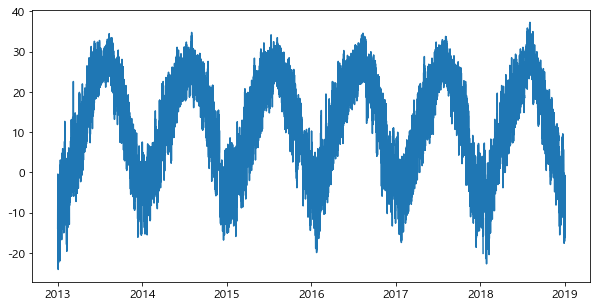

In [ ]:
plt.plot(paju['일시'], paju['기온(°C)'])

In [ ]:
temp_list = paju[paju['기온(°C)'].isnull()].index.to_list()

In [ ]:
temp_list

In [ ]:
for i in temp_list:
    if (i+1) in temp_list:
        temp_list.remove(i+1)
        new1 = (paju['기온(°C)'].iloc[i-2:i].sum() * 2) + (paju['기온(°C)'].iloc[i+2:i+4].sum() * 1)
        paju['기온(°C)'].iloc[i] = new1/6
        new2 = (paju['기온(°C)'].iloc[i-2:i].sum()* 1) + (paju['기온(°C)'].iloc[i+2:i+4].sum() * 2)
        paju['기온(°C)'].iloc[i+1] = new2/6
    else:
        paju['기온(°C)'].iloc[i] = (paju['기온(°C)'].iloc[i-2:i].sum() + paju['기온(°C)'].iloc[i+1:i+3].sum())/4

In [ ]:
paju.isnull().sum()

일시              0
지점              0
지점명             0
기온(°C)          0
강수량(mm)     49019
풍속(m/s)       110
습도(%)         129
적설(cm)      51514
지면온도(°C)      208
dtype: int64

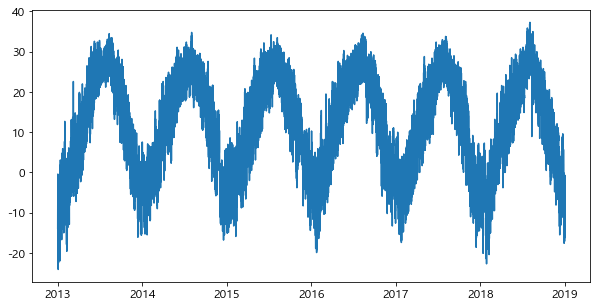

In [ ]:
plt.plot(paju['일시'], paju['기온(°C)'])

- 풍속

In [ ]:
paju['풍속(m/s)'].describe()

count    52474.000000
mean         1.551923
std          1.238951
min          0.000000
25%          0.600000
50%          1.300000
75%          2.300000
max         11.400000
Name: 풍속(m/s), dtype: float64

In [ ]:
paju[paju['풍속(m/s)'] == 0]

,일시,지점,지점명,기온(°C),강수량(mm),풍속(m/s),습도(%),적설(cm),지면온도(°C)
75,2013-01-04 03:00:00,99.0,파주,-21.1,NaN,0.0,79.0,NaN,-2.2
114,2013-01-05 18:00:00,99.0,파주,-6.6,NaN,0.0,70.0,NaN,-1.2
125,2013-01-06 05:00:00,99.0,파주,-17.5,NaN,0.0,82.0,NaN,-2.3
128,2013-01-06 08:00:00,99.0,파주,-18.1,NaN,0.0,82.0,NaN,-2.5
140,2013-01-06 20:00:00,99.0,파주,-10.3,NaN,0.0,79.0,NaN,-1.7
...,...,...,...,...,...,...,...,...,...
52579,2018-12-31 19:00:00,99.0,파주,-6.0,NaN,0.0,41.0,NaN,-7.4
52580,2018-12-31 20:00:00,99.0,파주,-7.5,NaN,0.0,53.0,NaN,-8.4
52581,2018-12-31 21:00:00,99.0,파주,-8.8,NaN,0.0,58.0,NaN,-9.3
52582,2018-12-31 22:00:00,99.0,파주,-9.8,NaN,0.0,63.0,NaN,-9.7


In [ ]:
paju[paju['풍속(m/s)'].isna()]

,일시,지점,지점명,기온(°C),강수량(mm),풍속(m/s),습도(%),적설(cm),지면온도(°C)
6129,2013-09-13 09:00:00,99,파주,21.225,NaN,NaN,NaN,NaN,NaN
8131,2013-12-05 19:00:00,99,파주,2.625,NaN,NaN,NaN,NaN,NaN
12925,2014-06-23 13:00:00,99.0,파주,22.775,7.0,NaN,NaN,NaN,NaN
14467,2014-08-26 19:00:00,99.0,파주,22.850,14.1,NaN,NaN,NaN,NaN
15446,2014-10-06 14:00:00,99.0,파주,20.300,NaN,NaN,36.0,NaN,26.7
...,...,...,...,...,...,...,...,...,...
50438,2018-10-03 14:00:00,99.0,파주,21.700,NaN,NaN,47.0,NaN,26.0
50439,2018-10-03 15:00:00,99,파주,22.475,NaN,NaN,NaN,NaN,NaN
50440,2018-10-03 16:00:00,99.0,파주,23.700,NaN,NaN,49.0,NaN,23.0
51612,2018-11-21 12:00:00,99,파주,6.025,NaN,NaN,NaN,NaN,NaN


- 강수량

In [ ]:
paju[paju['강수량(mm)'] == 0]

,일시,지점,지점명,기온(°C),강수량(mm),풍속(m/s),습도(%),적설(cm),지면온도(°C)
6,2013-01-01 06:00:00,99.0,파주,-11.2,0.0,1.9,74.0,NaN,-1.9
12,2013-01-01 12:00:00,99.0,파주,-4.8,0.0,1.1,77.0,NaN,-0.8
372,2013-01-16 12:00:00,99.0,파주,0.3,0.0,0.8,65.0,NaN,-0.5
543,2013-01-23 15:00:00,99.0,파주,2.5,0.0,2.2,96.0,NaN,0.3
861,2013-02-05 21:00:00,99.0,파주,1.0,0.0,0.1,84.0,7.5,0.2
...,...,...,...,...,...,...,...,...,...
51597,2018-11-20 21:00:00,99.0,파주,8.8,0.0,2.1,54.0,NaN,5.7
51894,2018-12-03 06:00:00,99.0,파주,8.0,0.0,1.1,64.0,NaN,5.5
51912,2018-12-04 00:00:00,99.0,파주,9.3,0.0,0.9,100.0,NaN,8.2
52224,2018-12-17 00:00:00,99.0,파주,-1.7,0.0,0.2,96.0,0.8,-1.3


In [ ]:
paju[paju['강수량(mm)'].isna()]

,일시,지점,지점명,기온(°C),강수량(mm),풍속(m/s),습도(%),적설(cm),지면온도(°C)
0,2013-01-01 00:00:00,99.0,파주,-13.9,NaN,0.9,77.0,NaN,-2.3
1,2013-01-01 01:00:00,99.0,파주,-12.8,NaN,1.5,74.0,NaN,-2.3
2,2013-01-01 02:00:00,99.0,파주,-12.9,NaN,1.8,75.0,NaN,-2.2
3,2013-01-01 03:00:00,99.0,파주,-12.8,NaN,1.7,74.0,NaN,-2.1
4,2013-01-01 04:00:00,99.0,파주,-12.3,NaN,1.3,72.0,NaN,-2.1
...,...,...,...,...,...,...,...,...,...
52579,2018-12-31 19:00:00,99.0,파주,-6.0,NaN,0.0,41.0,NaN,-7.4
52580,2018-12-31 20:00:00,99.0,파주,-7.5,NaN,0.0,53.0,NaN,-8.4
52581,2018-12-31 21:00:00,99.0,파주,-8.8,NaN,0.0,58.0,NaN,-9.3
52582,2018-12-31 22:00:00,99.0,파주,-9.8,NaN,0.0,63.0,NaN,-9.7


- 습도

In [ ]:
paju.describe().T

,count,mean,std,min,25%,50%,75%,max
기온(°C),52584.0,11.145416,11.685423,-24.1,1.5,12.2,21.1,37.3
강수량(mm),3565.0,1.690603,3.637854,0.0,0.1,0.5,1.7,46.9
풍속(m/s),52474.0,1.551923,1.238951,0.0,0.6,1.3,2.3,11.4
습도(%),52455.0,69.765782,21.334445,7.0,54.0,73.0,89.0,100.0
적설(cm),1070.0,2.476075,2.618036,0.0,1.0,1.5,3.0,14.5
지면온도(°C),52376.0,13.968123,12.974521,-40.1,1.3,13.8,23.8,62.1


In [ ]:
# 겨울과 여릉의 습도?  통계 _ 3월에 많이 건조60대 7~8 건조
# 비가 오는 날과 오지 않은 날
paju[paju['일시'] == '2013-03-01']

,일시,지점,지점명,기온(°C),강수량(mm),풍속(m/s),습도(%),적설(cm),지면온도(°C)
1416,2013-03-01,99.0,파주,7.0,0.1,1.7,87.0,NaN,2.9


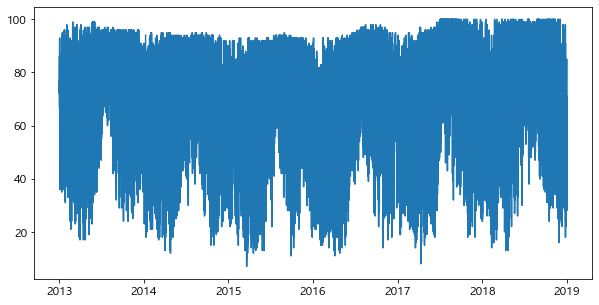

In [ ]:
plt.plot(paju['일시'], paju['습도(%)'])

In [ ]:
paju[paju['습도(%)'].isnull()]

,일시,지점,지점명,기온(°C),강수량(mm),풍속(m/s),습도(%),적설(cm),지면온도(°C)
6129,2013-09-13 09:00:00,99,파주,21.225,NaN,NaN,NaN,NaN,NaN
8131,2013-12-05 19:00:00,99,파주,2.625,NaN,NaN,NaN,NaN,NaN
8937,2014-01-08 09:00:00,99.0,파주,0.400,NaN,1.0,NaN,NaN,0.2
12925,2014-06-23 13:00:00,99.0,파주,22.775,7.0,NaN,NaN,NaN,NaN
14467,2014-08-26 19:00:00,99.0,파주,22.850,14.1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
50392,2018-10-01 16:00:00,99,파주,10.950,NaN,NaN,NaN,NaN,NaN
50393,2018-10-01 17:00:00,99,파주,13.600,NaN,NaN,NaN,NaN,NaN
50439,2018-10-03 15:00:00,99,파주,22.475,NaN,NaN,NaN,NaN,NaN
51612,2018-11-21 12:00:00,99,파주,6.025,NaN,NaN,NaN,NaN,NaN


In [ ]:
paju[paju['습도(%)']==0]

,일시,지점,지점명,기온(°C),강수량(mm),풍속(m/s),습도(%),적설(cm),지면온도(°C)


- 적설

In [ ]:
paju[paju['적설(cm)'].isnull()]

,일시,지점,지점명,기온(°C),강수량(mm),풍속(m/s),습도(%),적설(cm),지면온도(°C)
0,2013-01-01 00:00:00,99.0,파주,-13.9,NaN,0.9,77.0,NaN,-2.3
1,2013-01-01 01:00:00,99.0,파주,-12.8,NaN,1.5,74.0,NaN,-2.3
2,2013-01-01 02:00:00,99.0,파주,-12.9,NaN,1.8,75.0,NaN,-2.2
3,2013-01-01 03:00:00,99.0,파주,-12.8,NaN,1.7,74.0,NaN,-2.1
4,2013-01-01 04:00:00,99.0,파주,-12.3,NaN,1.3,72.0,NaN,-2.1
...,...,...,...,...,...,...,...,...,...
52579,2018-12-31 19:00:00,99.0,파주,-6.0,NaN,0.0,41.0,NaN,-7.4
52580,2018-12-31 20:00:00,99.0,파주,-7.5,NaN,0.0,53.0,NaN,-8.4
52581,2018-12-31 21:00:00,99.0,파주,-8.8,NaN,0.0,58.0,NaN,-9.3
52582,2018-12-31 22:00:00,99.0,파주,-9.8,NaN,0.0,63.0,NaN,-9.7


In [ ]:
paju[paju['적설(cm)']==0]

일시의 결측을 채워주어 지점명, 지점에 결측 발생 ==> 관측소마다 이름 채워넣기
기온의 결측은 앞뒤의 날씨의 평균으로 채워넣기 : 파주 기준 100개는원래 없던 행이고, 30일의 결측치
풍속과 습도-->

강수량과 적설,,

- 지면온도(°C)

In [ ]:
paju[paju['지면온도(°C)'].isnull()]

,일시,지점,지점명,기온(°C),강수량(mm),풍속(m/s),습도(%),적설(cm),지면온도(°C)
6129,2013-09-13 09:00:00,99,파주,21.225,NaN,NaN,NaN,NaN,NaN
8131,2013-12-05 19:00:00,99,파주,2.625,NaN,NaN,NaN,NaN,NaN
12925,2014-06-23 13:00:00,99.0,파주,22.775,7.0,NaN,NaN,NaN,NaN
14467,2014-08-26 19:00:00,99.0,파주,22.850,14.1,NaN,NaN,NaN,NaN
15755,2014-10-19 11:00:00,99.0,파주,10.050,NaN,1.2,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
50392,2018-10-01 16:00:00,99,파주,10.950,NaN,NaN,NaN,NaN,NaN
50393,2018-10-01 17:00:00,99,파주,13.600,NaN,NaN,NaN,NaN,NaN
50439,2018-10-03 15:00:00,99,파주,22.475,NaN,NaN,NaN,NaN,NaN
51612,2018-11-21 12:00:00,99,파주,6.025,NaN,NaN,NaN,NaN,NaN


### 수원

In [ ]:
suwon['지점명'] = suwon['지점명'].fillna('수원')
suwon['지점'] = suwon['지점'].fillna('119')

In [ ]:
suwon.isna().sum()

일시              0
지점              0
지점명             0
기온(°C)          0
강수량(mm)     47775
풍속(m/s)         1
습도(%)          81
적설(cm)      50663
지면온도(°C)        7
dtype: int64

In [ ]:
temp_list = suwon[suwon['기온(°C)'].isnull()].index.to_list()

In [ ]:
temp_list

[17520]

In [ ]:
for i in temp_list:
    suwon['기온(°C)'].iloc[i] = (suwon['기온(°C)'].iloc[i-2:i].sum() + suwon['기온(°C)'].iloc[i+1:i+3].sum())/4 

In [ ]:
suwon.iloc[17515:17525]

,일시,지점,지점명,기온(°C),강수량(mm),풍속(m/s),습도(%),적설(cm),지면온도(°C)
17515,2014-12-31 19:00:00,119,수원,-2.400,NaN,5.3,58.0,NaN,-2.5
17516,2014-12-31 20:00:00,119,수원,-3.100,NaN,4.8,46.0,NaN,-3.1
17517,2014-12-31 21:00:00,119,수원,-3.700,NaN,4.2,47.0,NaN,-3.5
17518,2014-12-31 22:00:00,119,수원,-4.100,NaN,5.5,51.0,NaN,-3.0
17519,2014-12-31 23:00:00,119,수원,-5.000,NaN,6.2,30.0,NaN,-4.1
17520,2015-01-01 00:00:00,119,수원,-5.525,NaN,4.2,NaN,NaN,NaN
17521,2015-01-01 01:00:00,119,수원,-6.200,NaN,5.2,34.0,NaN,-5.2
17522,2015-01-01 02:00:00,119,수원,-6.800,NaN,4.5,38.0,NaN,-5.4
17523,2015-01-01 03:00:00,119,수원,-7.100,NaN,3.7,39.0,NaN,-5.6
17524,2015-01-01 04:00:00,119,수원,-7.400,NaN,4.6,38.0,NaN,-5.8


In [ ]:
temp_list = suwon[suwon['풍속(m/s)'].isnull()].index.to_list()

In [ ]:
temp_list

[17227]

In [ ]:
suwon['풍속(m/s)'].describe().T

count    52583.000000
mean         1.803370
std          1.289674
min          0.000000
25%          0.800000
50%          1.600000
75%          2.600000
max          9.200000
Name: 풍속(m/s), dtype: float64

In [ ]:
suwon.iloc[temp_list[0]-15:temp_list[0]+16]

,일시,지점,지점명,기온(°C),강수량(mm),풍속(m/s),습도(%),적설(cm),지면온도(°C)
17212,2014-12-19 04:00:00,119,수원,-6.9,NaN,1.4,55.0,NaN,-5.2
17213,2014-12-19 05:00:00,119,수원,-6.8,NaN,1.7,51.0,NaN,-5.1
17214,2014-12-19 06:00:00,119,수원,-7.0,NaN,1.7,52.0,NaN,-5.0
17215,2014-12-19 07:00:00,119,수원,-7.0,NaN,1.4,51.0,NaN,-5.2
17216,2014-12-19 08:00:00,119,수원,-6.7,NaN,1.8,49.0,NaN,-4.9
17217,2014-12-19 09:00:00,119,수원,-5.6,NaN,2.5,45.0,NaN,-3.6
17218,2014-12-19 10:00:00,119,수원,-4.5,NaN,2.7,43.0,NaN,-2.0
17219,2014-12-19 11:00:00,119,수원,-2.8,NaN,3.0,39.0,NaN,-0.4
17220,2014-12-19 12:00:00,119,수원,-1.7,NaN,2.5,36.0,NaN,0.0
17221,2014-12-19 13:00:00,119,수원,-0.9,NaN,2.7,35.0,NaN,0.1


### 동두천

In [ ]:
dongducheon['지점명'] = dongducheon['지점명'].fillna('동두천')
dongducheon['지점'] = dongducheon['지점'].fillna('99')

In [ ]:
dongducheon.isna().sum()

일시              0
지점              0
지점명             0
기온(°C)          0
강수량(mm)     48715
풍속(m/s)        21
습도(%)          15
적설(cm)      51207
지면온도(°C)       41
dtype: int64

In [ ]:
temp_list = dongducheon[dongducheon['기온(°C)'].isnull()].index.to_list()

In [ ]:
for i in temp_list:
    if (i+1) in temp_list:
        temp_list.remove(i+1)
        new1 = (dongducheon['기온(°C)'].iloc[i-2:i].sum() * 2) + (dongducheon['기온(°C)'].iloc[i+2:i+4].sum() * 1)
        dongducheon['기온(°C)'].iloc[i] = new1/6
        new2 = (dongducheon['기온(°C)'].iloc[i-2:i].sum()* 1) + (dongducheon['기온(°C)'].iloc[i+2:i+4].sum() * 2)
        dongducheon['기온(°C)'].iloc[i+1] = new2/6
    else:
        dongducheon['기온(°C)'].iloc[i] = (dongducheon['기온(°C)'].iloc[i-2:i].sum() + dongducheon['기온(°C)'].iloc[i+1:i+3].sum())/4

### 이천

In [ ]:
icheon['지점명'] = icheon['지점명'].fillna('이천')
icheon['지점'] = icheon['지점'].fillna('203')

In [ ]:
icheon.isna().sum()

일시              0
지점              0
지점명             0
기온(°C)          0
강수량(mm)     48883
풍속(m/s)        75
습도(%)          39
적설(cm)      51655
지면온도(°C)       62
dtype: int64

In [ ]:
temp_list = icheon[icheon['기온(°C)'].isnull()].index.to_list()

for i in temp_list:
    if (i+1) in temp_list:
        temp_list.remove(i+1)
        new1 = (icheon['기온(°C)'].iloc[i-2:i].sum() * 2) + (icheon['기온(°C)'].iloc[i+2:i+4].sum() * 1)
        icheon['기온(°C)'].iloc[i] = new1/6
        new2 = (icheon['기온(°C)'].iloc[i-2:i].sum()* 1) + (icheon['기온(°C)'].iloc[i+2:i+4].sum() * 2)
        icheon['기온(°C)'].iloc[i+1] = new2/6
    else:
        icheon['기온(°C)'].iloc[i] = (icheon['기온(°C)'].iloc[i-2:i].sum() + icheon['기온(°C)'].iloc[i+1:i+3].sum())/4

### 양평

In [ ]:
yangpyeong

,일시,지점,지점명,기온(°C),강수량(mm),풍속(m/s),습도(%),적설(cm),지면온도(°C)
0,2013-01-01 00:00:00,202.0,양평,-12.6,NaN,0.5,83.0,NaN,-3.6
1,2013-01-01 01:00:00,202.0,양평,-12.6,NaN,0.3,88.0,NaN,-3.7
2,2013-01-01 02:00:00,202.0,양평,-13.1,NaN,0.5,87.0,NaN,-3.8
3,2013-01-01 03:00:00,202.0,양평,-13.4,NaN,0.5,90.0,NaN,-3.8
4,2013-01-01 04:00:00,202.0,양평,-13.7,NaN,1.1,85.0,NaN,-3.9
...,...,...,...,...,...,...,...,...,...
52579,2018-12-31 19:00:00,202.0,양평,-3.4,NaN,0.8,27.0,NaN,-4.4
52580,2018-12-31 20:00:00,202.0,양평,-5.1,NaN,0.6,42.0,NaN,-6.2
52581,2018-12-31 21:00:00,202.0,양평,-6.7,NaN,0.5,49.0,NaN,-7.2
52582,2018-12-31 22:00:00,202.0,양평,-7.4,NaN,0.2,54.0,NaN,-8.2


In [ ]:
yangpyeong['지점명'] = yangpyeong['지점명'].fillna('양평')
yangpyeong['지점'] = yangpyeong['지점'].fillna('202')

In [ ]:
yangpyeong.isna().sum()

일시              0
지점              0
지점명             0
기온(°C)          0
강수량(mm)     48781
풍속(m/s)        26
습도(%)         272
적설(cm)      52544
지면온도(°C)       29
dtype: int64

In [ ]:
temp_list = yangpyeong[yangpyeong['기온(°C)'].isnull()].index.to_list()

for i in temp_list:
    if (i+1) in temp_list:
        temp_list.remove(i+1)
        new1 = (yangpyeong['기온(°C)'].iloc[i-2:i].sum() * 2) + (yangpyeong['기온(°C)'].iloc[i+2:i+4].sum() * 1)
        yangpyeong['기온(°C)'].iloc[i] = new1/6
        new2 = (yangpyeong['기온(°C)'].iloc[i-2:i].sum()* 1) + (yangpyeong['기온(°C)'].iloc[i+2:i+4].sum() * 2)
        yangpyeong['기온(°C)'].iloc[i+1] = new2/6
    else:
        yangpyeong['기온(°C)'].iloc[i] = (yangpyeong['기온(°C)'].iloc[i-2:i].sum() + yangpyeong['기온(°C)'].iloc[i+1:i+3].sum())/4

In [ ]:
ggWeather = pd.concat([suwon, dongducheon, icheon, paju, yangpyeong], axis = 0, ignore_index=True)

In [ ]:
ggWeather

In [ ]:
ggWeather.isna().sum()

## 공공데이터 포털에 있는 데이터

한국가스공사_도시가스 수요 월별 기온 민감도 --> 월별 기온에 대한 가중치를 줄 수 있을것 같음 (https://www.data.go.kr/data/15066082/fileData.do)